# House Prices: Advanced Regression Techniques

## This Notebook has:

### **Data Preprocessing**
* Data cleaning and preprocessing
* Handling missing data and anomalies
* Transformation of variables

### **Feature Engineering**
* Extensive feature engineering
* Creating new features
* Combining existing features
* Removing insignificant features

### **Modeling**
* Various tuned and untuned Advanced Regressors
* Combination of Regressors
* Stacked Regression technique


#### Note:
* This includes few of my top submissions.

### Import Packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, ElasticNet, Ridge, Lasso
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: "%3f"%x)
get_ipython().run_line_magic('matplotlib', 'inline')


# ignore Deprecation Warning
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

### Read Data

In [2]:
# load dataset
train = pd.read_csv("/data/train.csv")
train_shape=train.shape[0]
print(train.shape)
train.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# Load the dataset for submission (the one on which our model will be evaluated by Kaggle)
# it contains exactly the same variables, but not the target

test = pd.read_csv("/data/test.csv")
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


# DATA CLEANING AND PREPROCESSING

### Join Data

In [4]:
df_columns = test.columns

y = train.SalePrice
train = train[df_columns]

df = pd.concat([train, test])

### Separate data into Numerical and Categorical Variables

In [5]:
# divide the data into numerical ("num") and categorical ("cat") features
num = list( test.loc[:,test.dtypes != 'object'].drop('Id',axis=1).columns.values )
cat = list( test.loc[:,test.dtypes == 'object'].columns.values )

In [6]:
# Find out how many missing values there are for the numerical and categorical features
# Data that needs good replacement of NaNs
nan_data = df[num].isnull().sum()
nan_data = nan_data[nan_data > 0]
nan_data = nan_data.sort_values(ascending=False)
print(nan_data)
print('**'*40)
nan_data = df[cat].isnull().sum()
nan_data = nan_data[nan_data > 0]
nan_data = nan_data.sort_values(ascending=False)
print(nan_data)


LotFrontage     486
GarageYrBlt     159
MasVnrArea       23
BsmtHalfBath      2
BsmtFullBath      2
GarageArea        1
GarageCars        1
TotalBsmtSF       1
BsmtUnfSF         1
BsmtFinSF2        1
BsmtFinSF1        1
dtype: int64
********************************************************************************
PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
GarageCond       159
GarageQual       159
GarageFinish     159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MSZoning           4
Functional         2
Utilities          2
Exterior1st        1
SaleType           1
Exterior2nd        1
KitchenQual        1
Electrical         1
dtype: int64


In [7]:
# Filling missing values for numerical features. Most of the NAN should mean that 
# the corresponding facillity/structure doesn't exist, so I use zero for most cases

# Use zero
df.MasVnrArea.fillna(0, inplace=True)
df.BsmtHalfBath.fillna(0, inplace=True)
df.BsmtFullBath.fillna(0, inplace=True)
df.GarageArea.fillna(0, inplace=True)
df.GarageCars.fillna(0, inplace=True)
df.TotalBsmtSF.fillna(0, inplace=True)
df.BsmtUnfSF.fillna(0, inplace=True)
df.BsmtFinSF2.fillna(0, inplace=True)
df.BsmtFinSF1.fillna(0, inplace=True)


# NAN should mean no garage. I temporarily use yr = 0 here. Will come back to this later. 
df.GarageYrBlt.fillna(0, inplace=True)

In [8]:
# leaving these as None is the best value for it - not missing data - just not applicable
nan_data = df.isnull().sum().sort_values(ascending=False)
nan_data[nan_data > 0]

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageQual       159
GarageFinish     159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MSZoning           4
Utilities          2
Functional         2
SaleType           1
Electrical         1
KitchenQual        1
Exterior2nd        1
Exterior1st        1
dtype: int64

In [9]:
# Fill Nulls with 'NA'
df.PoolQC.fillna('NA', inplace=True)
df.MiscFeature.fillna('NA', inplace=True)
df.Alley.fillna('NA', inplace=True)
df.Fence.fillna('NA', inplace=True)
df.FireplaceQu.fillna('NA', inplace=True)
df.LotFrontage.fillna(0., inplace=True)
df.GarageCond.fillna('NA', inplace=True)
df.GarageType.fillna('NA', inplace=True)
df.GarageFinish.fillna('NA', inplace=True)
df.GarageQual.fillna('NA', inplace=True)
df.BsmtExposure.fillna('NA', inplace=True)
df.BsmtFinType2.fillna('NA', inplace=True)
df.BsmtFinType1.fillna('NA', inplace=True)
df.BsmtCond.fillna('NA', inplace=True)
df.BsmtQual.fillna('NA', inplace=True)
df.MasVnrType.fillna('None', inplace=True)

# Fill Nulls with 0
df.MasVnrArea.fillna(0, inplace=True)
df.GarageArea.fillna(0, inplace=True)
df.BsmtUnfSF.fillna(0, inplace=True)
df.BsmtFinSF2.fillna(0, inplace=True)
df.BsmtFullBath.fillna(0, inplace=True)
df.BsmtHalfBath.fillna(0, inplace=True)
df.BsmtFinSF1.fillna(0, inplace=True)
df.KitchenQual.fillna('TA', inplace=True)
df.Functional.fillna(0, inplace=True)
df.Utilities.fillna(0, inplace=True)
# df.MSZoning.fillna(0, inplace=True)
df.Exterior2nd.fillna(df.Exterior2nd.mode().values[0], inplace=True)
df.Electrical.fillna(df.Electrical.mode().values[0], inplace=True)
df.Exterior1st.fillna(df.Exterior1st.mode().values[0], inplace=True)
df.GarageCars.fillna(0, inplace=True)
df.TotalBsmtSF.fillna(0, inplace=True)
df.SaleType.fillna(df.SaleType.mode().values[0], inplace=True)
df.GarageType.fillna("NoGarage", inplace=True)

In [10]:
# We should have only MSZoning Left with 4 nulls
nan_data = df.isnull().sum().sort_values(ascending=False)
nan_data[nan_data > 0]


MSZoning    4
dtype: int64

In [11]:
# Handling missing values in MSZoning
for i in df.Neighborhood.unique():
    if (df.MSZoning[df.Neighborhood == i].isnull().sum()) > 0:
        df.loc[df.Neighborhood == i,'MSZoning'] = df.loc[df.Neighborhood == i,'MSZoning'].fillna(df.loc[df.Neighborhood == i,'MSZoning'].mode()[0])

In [12]:
# Should return an empty series
nan_data = df.isnull().sum().sort_values(ascending=False)
nan_data[nan_data > 0]

Series([], dtype: int64)

In [13]:
# Mapping Categorical variable with corresponding ranks -  Text to Num

df['ExterQual'] = df.ExterQual.replace(dict(Ex=5, Gd=4, TA=3, Fa=2, Po=1))
df['ExterCond'] = df.ExterCond.replace(dict(Ex=5, Gd=4, TA=3, Fa=2, Po=1))
df['BsmtQual'] = df.BsmtQual.replace(dict(Ex=5, Gd=4, TA=3, Fa=2, Po=1, NA=0))
df['BsmtCond'] = df.BsmtCond.replace(dict(Ex=5, Gd=4, TA=3, Fa=2, Po=1, NA=0))
df['BsmtExposure'] = df.BsmtExposure.replace(dict(Gd=4, Av=3, Mn=2, No=1, NA=0))
df['BsmtFinType1'] = df.BsmtFinType1.replace(dict(GLQ=6, ALQ=5, BLQ=4, Rec=3, LwQ=2, Unf=1, NA=0))
df['BsmtFinType2'] = df.BsmtFinType2.replace(dict(GLQ=6, ALQ=5, BLQ=4, Rec=3, LwQ=2, Unf=1, NA=0))
df['HeatingQC'] = df.HeatingQC.replace(dict(Ex=5, Gd=4, TA=3, Fa=2, Po=1))
df['KitchenQual'] = df.KitchenQual.replace(dict(Ex=5, Gd=4, TA=3, Fa=2, Po=1))
df['Functional'] = df.Functional.replace(dict(Typ=8, Min1=7, Min2=6, Mod=5, Maj1=4, Maj2=3, Sev=2, Sal=1))
df['FireplaceQu'] = df.FireplaceQu.replace(dict(Ex=5, Gd=4, TA=3, Fa=2, Po=1, NA=0))
df['GarageQual'] = df.GarageQual.replace(dict(Ex=5, Gd=4, TA=3, Fa=2, Po=1, NA=0))
df['GarageCond'] = df.GarageCond.replace(dict(Ex=5, Gd=4, TA=3, Fa=2, Po=1, NA=0))
df['PoolQC'] = df.PoolQC.replace(dict(Ex=5, Gd=4, TA=3, Fa=2, NA=1))
df['Fence'] = df.Fence.replace(dict(GdPrv=5, MnPrv=4, GdWo=3, MnWw=2, NA=1))
df['Alley'] = df.Alley.replace(dict(Grvl=3, Pave=2, NA=1))
df['LotShape'] = df.LotShape.replace(dict(Reg=4, IR1=3, IR2=2, IR3=1))
df['Utilities'] = df.Utilities.replace(dict(AllPub=4, NoSewr=3, NoSeWa=2, ELO=1))
df['LotConfig'] = df.LotConfig.replace(dict(Inside=5, Corner=4, CulDSac=3, FR2=2, FR3=1))
df['LandContour'] = df.LandContour.replace(dict(Lvl=4, Bnk=3, HLS=2, Low=1))
df['LandSlope'] = df.LandSlope.replace(dict(Gtl=3, Mod=2, Sev=1))
df['MSZoning']=df.MSZoning.replace(({'RL':1, 'RM':2, 'C (all)':3, 'FV':4, 'RH':5}))
df['Street']=df.Street.replace(dict(Grvl=2, Pave=1))
# df['Neighborhood'] = df.Neighborhood.replace(dict(NAmes=1,CollgCr=2,OldTown=3,Edwards=4,Somerst=5,Gilbert=6,
#                                                   NridgHt=7,Sawyer=8,NWAmes=9,SawyerW=10,BrkSide=11,Crawfor=12,
#                                                   Mitchel=13,NoRidge=14,Timber=15,IDOTRR=16,ClearCr=17,StoneBr=18,
#                                                   SWISU=19,MeadowV=20,Blmngtn=21,BrDale=22,Veenker=23,NPkVill=24,Blueste=25))

# FEATURE ENGINEERING

### Adding New Features

In [14]:
#Add New Features
df.loc[(df.PoolArea>0), ['MiscFeature']] = 'Pool'
df.loc[(df.PoolArea>0), ['MiscVal']] = df.loc[(df.PoolArea>0),['MiscVal', 'PoolArea']].apply(lambda x: (x.MiscVal + x.PoolArea), axis=1)

df['TotalExtraPoints'] = df.HeatingQC + df.PoolQC + df.FireplaceQu + df.KitchenQual
df['TotalPoints'] = (df.ExterQual + df.FireplaceQu + df.GarageQual + df.KitchenQual +
                      df.BsmtQual + df.BsmtExposure + df.BsmtFinType1 + df.PoolQC + 
                      df.ExterCond + df.BsmtCond + df.GarageCond + df.OverallCond +
                      df.BsmtFinType2 + df.HeatingQC ) + df.OverallQual**2


df['GarageArea_x_Car'] = df.GarageArea * df.GarageCars

df['TotalBsmtSF_x_Bsm'] = df.TotalBsmtSF * df['1stFlrSF']

# We don´t have a feature with all construct area, maybe it is an interesting feature to create.
df['ConstructArea'] = (df.TotalBsmtSF + df.WoodDeckSF + df.GrLivArea +df['3SsnPorch']+
                       df.OpenPorchSF + df.ScreenPorch + df.EnclosedPorch +
                       df.MasVnrArea + df.GarageArea + df.PoolArea )

#df['TotalArea'] = df.ConstructArea + df.LotArea

df['Garage_Newest'] = df.YearBuilt > df.GarageYrBlt
df.Garage_Newest = df.Garage_Newest.apply(lambda x: 1 if x else 0)

df['TotalPorchSF'] = df.OpenPorchSF + df.EnclosedPorch + df.ScreenPorch + df.WoodDeckSF+df['3SsnPorch']
df.EnclosedPorch = df.EnclosedPorch.apply(lambda x: 1 if x else 0)

df['LotAreaMultSlope'] = df.LotArea * df.LandSlope


df['BsmtSFPoints'] = (df.BsmtQual**2 + df.BsmtCond + df.BsmtExposure +
                      df.BsmtFinType1 + df.BsmtFinType2)


df['BsmtSFMultPoints'] = df.TotalBsmtSF * (df.BsmtQual**2 + df.BsmtCond + df.BsmtExposure +
                                           df.BsmtFinType1 + df.BsmtFinType2)

df['TotBathrooms'] = df.FullBath + (df.HalfBath*0.5) + df.BsmtFullBath + (df.BsmtHalfBath*0.5)
df.FullBath = df.FullBath.apply(lambda x: 1 if x else 0)
df.HalfBath = df.HalfBath.apply(lambda x: 1 if x else 0)
df.BsmtFullBath = df.BsmtFullBath.apply(lambda x: 1 if x else 0)
df.BsmtHalfBath = df.BsmtHalfBath.apply(lambda x: 1 if x else 0)

### Create new features from existing data

In [15]:
# Create new features from existing data
df['TotalBath'] = df.FullBath + df.BsmtFullBath + 0.5 * (df.BsmtHalfBath + df.HalfBath)
df['TotalSF'] = df.TotalBsmtSF + df.GrLivArea

df["IsRegularLotShape"] = (df.LotShape == "Reg") * 1
df["IsLandLevel"] = (df.LandContour == "Lvl") * 1
df["IsLandSlopeGntl"] = (df.LandSlope == "Gtl") * 1
df["IsElectricalSBrkr"] = (df.Electrical == "SBrkr") * 1
df["IsGarageDetached"] = (df.GarageType == "Detchd") * 1
df["IsPavedDrive"] = (df.PavedDrive == "Y") * 1
df["HasShed"] = (df.MiscFeature == "Shed") * 1

# these features jumped my score from 0.11875 to 0.11833

df.loc[df.Neighborhood == 'NridgHt', "Neighborhood_Good"] = 1
df.loc[df.Neighborhood == 'Crawfor', "Neighborhood_Good"] = 1
df.loc[df.Neighborhood == 'StoneBr', "Neighborhood_Good"] = 1
df.loc[df.Neighborhood == 'Somerst', "Neighborhood_Good"] = 1
df.loc[df.Neighborhood == 'NoRidge', "Neighborhood_Good"] = 1
df["Neighborhood_Good"].fillna(0, inplace=True)


# jumped the score from 0.11833 to 0.11819
df["SaleCondition_PriceDown"] = df.SaleCondition.replace({'Abnorml': 1, 'Alloca': 1, 'AdjLand': 1, 'Family': 1, 'Normal': 0, 'Partial': 0})

# House completed before sale or not
df["BoughtOffPlan"] = df.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, "Family" : 0, "Normal" : 0, "Partial" : 1})


area_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
             'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF',
             'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'LowQualFinSF', 'PoolArea' ]
df["TotalArea"] = df[area_cols].sum(axis=1)


# If YearRemodAdd != YearBuilt, then a remodeling took place at some point.
df["Remodeled"] = (df["YearRemodAdd"] != df["YearBuilt"]) * 1

# Did a remodeling happen in the year the house was sold?
df["RecentRemodel"] = (df["YearRemodAdd"] == df["YrSold"]) * 1

df["Age"] = 2020 - df["YearBuilt"]
df["TimeSinceSold"] = 2020 - df["YrSold"]


/opt/conda/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


### Simplify existing features - squash into smaller groups

In [16]:
# Create new features
# Simplify existing features - squash into smaller groups
# existing features
df['OverallQual_simple'] = df.OverallQual.replace({1:1, 2:1, 3:1,4:2, 5:2, 6:2, 7:3, 8:3, 9:3, 10:3})
df['OverallCond_simple'] = df.OverallCond.replace({1:1, 2:1, 3:1,4:2, 5:2, 6:2,7:3, 8:3, 9:3, 10:3})
# convert from categorical to ordinal with smaller groups
df['ExterQual_simple'] = df.ExterQual.replace({5:3, 4:3, 3:2, 2:2, 1:1})
df['ExterCond_simple'] = df.ExterCond.replace({5:3, 4:3, 3:2, 2:2, 1:1})
df['BsmtQual_simple'] = df.BsmtQual.replace({5:3, 4:3, 3:2, 2:2, 1:1})
df['BsmtCond_simple'] = df.BsmtCond.replace({5:3, 4:3, 3:2, 2:2, 1:1})
df['BsmtFinType1_simple'] = df.BsmtFinType1.replace({6:3, 5:3, 4:2, 3:2, 2:1, 1:1})
df['BsmtFinType2_simple'] = df.BsmtFinType2.replace({6:3, 5:3, 4:2, 3:2, 2:1, 1:1})
df['HeatingQC_simple'] = df.HeatingQC.replace({5:3, 4:3, 3:2, 2:2, 1:1})
df['KitchenQual_simple'] = df.KitchenQual.replace({5:3, 4:3, 3:2, 2:2, 1:1})
df['Functional_simple'] = df.Functional.replace({8:4, 7:3, 7:3, 6:3, 5:2,4:2, 3:1, 2:1})
df['GarageQual_simple'] = df.GarageQual.replace({5:3, 4:3, 3:2, 2:2, 1:1})
df['GarageCond_simple'] = df.GarageCond.replace({5:3, 4:3, 3:2, 2:2, 1:1})
df['PoolQC_simple'] = df.PoolQC.replace({5:3, 4:3, 3:2, 2:2, 1:1})
df['FireplaceQu_simple'] = df.FireplaceQu.replace({5:3, 4:3, 3:2, 2:2, 1:1})

In [17]:
df['YrBltAndRemod']=df['YearBuilt']+df['YearRemodAdd']
df['TotalSF_SF']=df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

df['Total_sqr_footage'] = (df['BsmtFinSF1'] + df['BsmtFinSF2'] +df['1stFlrSF'] + df['2ndFlrSF'])

#df['Total_Bathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) +df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))

#df['Total_porch_sf'] = (df['OpenPorchSF'] + df['3SsnPorch'] +df['EnclosedPorch'] + df['ScreenPorch'] + df['WoodDeckSF'])
df['haspool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df['has2ndfloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
df['hasgarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
df['hasbsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df['hasfireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)


### Converting categorical data with numerical features into categories 

In [18]:
# Converting categorical data with numerical features into categories 
# NOTE:- pd.get_dummies will one hot encode these columns now
# MSSubClass, MoSold
df['MSSubClass'] = df.MSSubClass.astype('category')
df['MoSold'] = df.MoSold.astype('category')
df['GarageYrBlt'] = df.GarageYrBlt.astype('category')
df['Neighborhood'] = df.Neighborhood.astype('category')
df['LotConfig'] = df.LotConfig.astype('category')
df['Condition1'] = df.Condition1.astype('category')
df['Condition2'] = df.Condition1.astype('category')
df['BldgType'] = df.BldgType.astype('category')
df['HouseStyle'] = df.HouseStyle.astype('category')
df['RoofStyle'] = df.RoofStyle.astype('category')
df['Exterior1st'] = df.Exterior1st.astype('category')
df['MasVnrArea'] = df.MasVnrArea.astype('category')
df['RoofMatl'] = df.RoofMatl.astype('category')
df['MasVnrType'] = df.MasVnrType.astype('category')
df['Foundation'] = df.Foundation.astype('category')
df['SaleCondition'] = df.SaleCondition.astype('category')
df['SaleType'] = df.SaleType.astype('category')
df['Exterior2nd'] = df.Exterior2nd.astype('category')
df['Heating'] = df.Heating.astype('category')
df['Electrical'] = df.Electrical.astype('category')
df['BedroomAbvGr'] = df.BedroomAbvGr.astype('category')
df['KitchenAbvGr'] = df.KitchenAbvGr.astype('category')
df['TotRmsAbvGrd'] = df.TotRmsAbvGrd.astype('category')
df['Fireplaces'] = df.Fireplaces.astype('category')
df['GarageType'] = df.GarageType.astype('category')
df['GarageFinish'] = df.GarageFinish.astype('category')
df['GarageCars'] = df.GarageCars.astype('category')
df['PavedDrive'] = df.PavedDrive.astype('category')

### Differentiate numerical features (minus the target) and categorical features

In [19]:
# Differentiate numerical features (minus the target) and categorical features
categorical_features = df.select_dtypes(include = ["object", "category"]).columns
numerical_features = df.select_dtypes(exclude = ["object", "category"]).columns
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
df_num = df[numerical_features]
df_cat = df[categorical_features]

Numerical features : 101
Categorical features : 30


In [20]:
## Check for missing values
df_num.isnull().values.sum(), df_cat.isnull().values.sum()

(0, 0)

### Handling skewed features

In [21]:
skewness = df_num.apply(skew)
skewness = skewness[abs(skewness) > 0.5]
skewed_features = skewness.index
df_num[skewed_features] = df_num[skewed_features].applymap(np.log1p)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [22]:
# # print the skewness of each numerical feature
for i in df_num.columns.tolist():
    print(i+': {}'.format(round(skew(df[i]),2)))

Id: 0.0
MSZoning: 2.67
LotFrontage: 0.02
LotArea: 12.82
Street: 15.5
Alley: 3.9
LotShape: -1.26
LandContour: -3.4
Utilities: -33.97
LandSlope: -4.98
OverallQual: 0.2
OverallCond: 0.57
YearBuilt: -0.6
YearRemodAdd: -0.45
ExterQual: 0.79
ExterCond: 1.32
BsmtQual: -1.27
BsmtCond: -3.6
BsmtExposure: 1.12
BsmtFinType1: -0.15
BsmtFinSF1: 1.43
BsmtFinType2: 3.15
BsmtFinSF2: 4.15
BsmtUnfSF: 0.92
TotalBsmtSF: 1.16
HeatingQC: -0.55
1stFlrSF: 1.47
2ndFlrSF: 0.86
LowQualFinSF: 12.09
GrLivArea: 1.27
BsmtFullBath: 0.34
BsmtHalfBath: 3.71
FullBath: -15.5
HalfBath: 0.53
KitchenQual: 0.44
Functional: -5.35
FireplaceQu: 0.17
GarageArea: 0.24
GarageQual: -3.26
GarageCond: -3.38
WoodDeckSF: 1.84
OpenPorchSF: 2.54
EnclosedPorch: 1.88
3SsnPorch: 11.38
ScreenPorch: 3.95
PoolArea: 16.9
PoolQC: 19.12
Fence: 1.75
MiscVal: 21.77
YrSold: 0.13
TotalExtraPoints: 0.19
TotalPoints: 0.6
GarageArea_x_Car: 1.42
TotalBsmtSF_x_Bsm: 7.96
ConstructArea: 1.45
Garage_Newest: 3.68
TotalPorchSF: 1.38
LotAreaMultSlope: 3.68
Bsmt

### Encoding Categorical Variables

In [23]:
# One hot encoding the categorical variables

df_cat = pd.get_dummies(df_cat)

### Separating Train and Test Data

In [24]:
df = pd.concat([df_num, df_cat], axis=1)
# scaler = StandardScaler()
# df[numerical_features] = scaler.fit_transform(df[numerical_features])

X_train = df[:train_shape]
X_test = df[train_shape:]
print(X_train.shape, X_test.shape)

(1460, 877) (1459, 877)


### Apply Log Transform

In [25]:
# log transform the sale price


## After prdictions are made - we need to convert them back to exponential form
y = np.log1p(y)
# y.rename(columns={ y.columns[0]: "y" }, inplace = True)

# MODELING

### Defining some functions to measure performance

In [26]:
from sklearn.model_selection import KFold
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X_train):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

### Create a list of suitable model parameters

In [27]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

### Defining Models / Pipelines / Stacked Regressors

In [28]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

In [29]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt',
                                min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)

In [30]:
# !pip install lightgbm
from lightgbm import LGBMRegressor
lightgbm = LGBMRegressor(objective='regression', 
                           num_leaves=4,
                           learning_rate=0.01, 
                           n_estimators=5000,
                           max_bin=200, 
                           bagging_fraction=0.75,
                           bagging_freq=5, 
                           bagging_seed=7,
                           feature_fraction=0.2,
                           feature_fraction_seed=7,
                           verbose=-1)

In [31]:
import xgboost as xgb
xgboost = xgb.XGBRegressor(learning_rate=0.01,n_estimators=3460,max_depth=3, min_child_weight=0,
                           gamma=0, subsample=0.7,colsample_bytree=0.7,objective='reg:linear',
                           nthread=-1,scale_pos_weight=1,seed=27,reg_alpha=0.00006)

In [32]:
from mlxtend.regressor import StackingCVRegressor
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,use_features_in_secondary=True)


#### Performance scoring

In [33]:
import datetime
score = cv_rmse(ridge)
print("RIDGE: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.datetime.now(), )

score = cv_rmse(lasso)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.datetime.now(), )

score = cv_rmse(elasticnet)
print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.datetime.now(), )

score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.datetime.now(), )

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.datetime.now(), )

score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.datetime.now(), )

score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.datetime.now(), )


print('Done')

RIDGE: 0.1256 (0.0248)
 2020-07-26 09:07:27.514092
LASSO: 0.1210 (0.0240)
 2020-07-26 09:10:51.662197
elastic net: 0.1209 (0.0240)
 2020-07-26 09:18:29.387597
SVR: 0.1224 (0.0315)
 2020-07-26 09:19:00.447339
lightgbm: 0.1185 (0.0173)
 2020-07-26 09:19:17.944521
gbr: 0.1184 (0.0232)
 2020-07-26 09:21:20.527388
[09:21:20] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[09:22:59] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[09:22:59] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[09:24:37] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[09:24:37] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[09:26:15] WARNING: /workspace/src/objective/regressio

# PREDICTIONS

### Stacked Regressor

In [34]:
stack_gen_model = stack_gen.fit(X_train, y)

preds_sg = stack_gen_model.predict(np.array(X_test))

sg_preds = pd.DataFrame(dict(SalePrice=np.expm1(preds_sg), Id=test.Id))
sg_preds.head()

[09:45:35] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[09:47:01] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[09:47:01] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[09:48:30] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[09:48:30] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[09:49:57] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[09:49:57] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[09:51:24] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of re

,SalePrice,Id
0,114759.468750,1461
1,161395.312500,1462
2,187720.812500,1463
3,198469.687500,1464
4,188314.687500,1465


### Ridge

In [35]:
model_ridge = ridge
model_ridge.fit(X_train, y)

preds_r = model_ridge.predict(X_test)

ridge_preds = pd.DataFrame(dict(SalePrice=np.expm1(preds_r), Id=test.Id))
ridge_preds.head()

,SalePrice,Id
0,115239.510126,1461
1,150724.148444,1462
2,182128.448500,1463
3,190481.951753,1464
4,192087.280597,1465


### Lasso

In [36]:
model_lasso = lasso
model_lasso.fit(X_train, y)

preds_l = model_lasso.predict(X_test)

lasso_preds = pd.DataFrame(dict(SalePrice=np.expm1(preds_l), Id=test.Id))
lasso_preds.head()

,SalePrice,Id
0,116115.592109,1461
1,158371.996138,1462
2,181103.879318,1463
3,196012.281692,1464
4,197467.241447,1465


### XGBoost

In [37]:
# import xgboost as xgb

regr = xgboost
regr.fit(X_train,y)
y_pred_xgb = regr.predict(X_test)
xgb_preds = pd.DataFrame(dict(SalePrice=np.expm1(y_pred_xgb), Id=test.Id))

xgb_preds.head()

[09:58:34] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[10:00:21] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


,SalePrice,Id
0,125964.453125,1461
1,161375.453125,1462
2,185708.328125,1463
3,192559.781250,1464
4,189218.031250,1465


XGB train mse: 0.002254344079696241


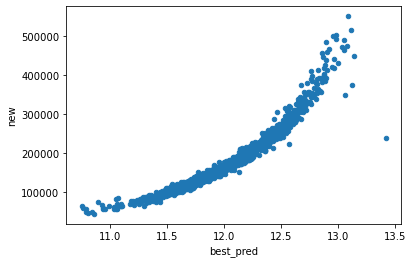

In [38]:
# residuals from best performing method for validation
y_pred_xgb_train = regr.predict(X_train)
print('XGB train mse: {}'.format(mean_squared_error(y, y_pred_xgb_train)))
pred_to_plot = pd.DataFrame(dict(best_pred=preds_l, new=np.expm1(y_pred_xgb)))
pred_to_plot.plot(x='best_pred', y='new', kind='scatter')

### Light Gradient Boost

In [39]:
light_gbm_model = lightgbm.fit(X_train, y)
lightgbm_predictions = light_gbm_model.predict(X_test)
pred_lgbm = pd.DataFrame(dict(SalePrice=np.expm1(lightgbm_predictions), Id=test.Id))

pred_lgbm.head()

,SalePrice,Id
0,121947.807972,1461
1,165969.048346,1462
2,182412.940948,1463
3,188135.737749,1464
4,192992.713102,1465


### Gradient Boost

In [40]:
gbr_model = gbr.fit(X_train, y)
gbr_predictions = gbr_model.predict(X_test)
pred_gbr = pd.DataFrame(dict(SalePrice=np.expm1(gbr_predictions), Id=test.Id))

pred_gbr.head()

,SalePrice,Id
0,121377.552968,1461
1,167931.632857,1462
2,196017.767101,1463
3,198826.651598,1464
4,184258.618978,1465


### Support Vector

In [41]:
# from sklearn.svm import SVR
SVR_model = svr
SVR_model.fit(X_train, y)

# to evaluate the models
from sklearn.metrics import mean_squared_error

pred_svr = SVR_model.predict(X_train)
print('SVR train mse: {}'.format(mean_squared_error(y, pred_svr)))
pred_svr = SVR_model.predict(X_test)
preds_svr = pd.DataFrame(dict(SalePrice=np.expm1(pred_svr), Id=test.Id))

preds_svr.head()

SVR train mse: 0.011414852069105998


,SalePrice,Id
0,120285.064406,1461
1,163474.592381,1462
2,195175.205111,1463
3,199953.129595,1464
4,191560.227461,1465


### Elastic Net

In [42]:
elastic_net_model = elasticnet.fit(X_train, y)
elastic_net_predictions = elastic_net_model.predict(X_test)
pred_enet = pd.DataFrame(dict(SalePrice=np.expm1(elastic_net_predictions), Id=test.Id))

pred_enet.head()

,SalePrice,Id
0,116115.592109,1461
1,158371.996138,1462
2,181103.879318,1463
3,196012.281692,1464
4,197467.241447,1465


### Random Forest

RF train mse: 0.03631071719496055


,SalePrice,Id
0,146069.599441,1461
1,152909.740394,1462
2,151890.130487,1463
3,168578.492046,1464
4,201056.559730,1465


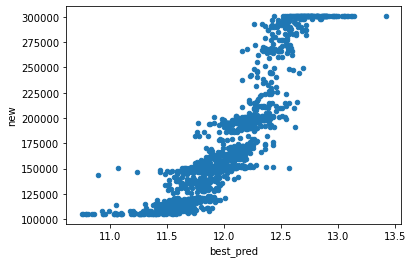

In [43]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, y)
y_pred_rf = regr.predict(X_test)
# residuals from best performing method for validation
y_pred_rf_train = regr.predict(X_train)
print('RF train mse: {}'.format(mean_squared_error(y, y_pred_rf_train)))
pred_to_plot = pd.DataFrame(dict(best_pred=preds_l, new=np.expm1(y_pred_rf)))
pred_to_plot.plot(x='best_pred', y='new', kind='scatter')


rf_preds = pd.DataFrame(dict(SalePrice=np.expm1(y_pred_rf), Id=test.Id))

rf_preds.head()


### Stacked Regressor Combination 2

In [44]:
#STACKED REGRESSOR 1
stack_gen1 = StackingCVRegressor(regressors=(lasso,elasticnet),meta_regressor=xgboost,use_features_in_secondary=True)


stack_gen_model1 = stack_gen1.fit(np.array(X_train),np.array(y))
preds_sg1 = stack_gen_model1.predict(np.array(X_test))

sg_preds1 = pd.DataFrame(dict(SalePrice=np.expm1(preds_sg1), Id=test.Id))
sg_preds1.head()

[10:07:50] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[10:09:37] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


,SalePrice,Id
0,117414.398438,1461
1,157178.718750,1462
2,182598.640625,1463
3,194725.406250,1464
4,189724.703125,1465


### Combined Predictions
Their weights can be varied

In [45]:
#Lasso + SR
preds_comb1 = 0.6 * preds_l + 0.4 * preds_sg
comb_preds1 = pd.DataFrame(dict(SalePrice=np.expm1(preds_comb1), Id=test.Id))
comb_preds1.head()

,SalePrice,Id
0,115571.251657,1461
1,159574.510241,1462
2,183722.209938,1463
3,196991.589105,1464
4,193754.068235,1465


In [46]:
#SR + ENet
preds_comb2 = 0.65 * elastic_net_predictions + 0.35 * preds_sg
comb_preds2 = pd.DataFrame(dict(SalePrice=np.expm1(preds_comb2), Id=test.Id))
comb_preds2.head()

,SalePrice,Id
0,115639.113060,1461
1,159423.650552,1462
2,183392.870505,1463
3,196868.873403,1464
4,194214.311410,1465


### Saving a few cominations for submission

In [47]:
sg_preds.to_csv('/submissions/submission_Stacked_Reg_LogTranform_Tuned.csv',index=False)
sg_preds1.to_csv('/submissions/submission_Stacked_Reg1_LogTranform_Tuned.csv',index=False)
comb_preds1.to_csv('/submissions/submission_Lasso_Stacked_Reg_LogTransform_Tuned.csv',index=False)
comb_preds2.to_csv('/submissions/submission_Stacked_Reg_ENet_LogTransform_Tuned.csv',index=False)